## Récupérer coordonnées ballons click

In [59]:
import cv2

# Variables globales
penalty_positions = []  # Liste pour stocker les positions et frames des pénalités

def click_event(event, x, y, flags, param):
    """
    Fonction de gestion des clics de souris.
    """
    global penalty_positions, frame_index, frame
    if event == cv2.EVENT_LBUTTONDOWN:  # Clic gauche
        penalty_positions.append((frame_index, (x, y)))
        print(f"Pénalité détectée à la frame {frame_index}, position : x={x}, y={y}")
        # Dessiner un point rouge sur la frame actuelle
        cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)  # Point rouge

# Charger la vidéo
video_path = 'penalty2.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Erreur: Impossible de lire la vidéo.")
    exit()

# Récupérer les dimensions et le FPS de la vidéo
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(f"Dimensions de la vidéo : {width}x{height}, FPS : {fps}")

frame_index = 0  # Indice de la frame actuelle

# Afficher la vidéo et attendre les clics
cv2.namedWindow("Video", cv2.WINDOW_NORMAL)  # Créer une fenêtre redimensionnable
cv2.resizeWindow("Video", width, height)  # Ajuster la taille de la fenêtre à celle de la vidéo
cv2.setMouseCallback("Video", click_event)  # Associer la gestion des clics

while True:
    ret, frame = cap.read()
    if not ret:
        print("Fin de la vidéo.")
        break

    # Afficher la vidéo avec les annotations (points rouges déjà ajoutés)
    cv2.imshow("Video", frame)
    frame_index += 1

    # Quitter si 'q' est pressé
    if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Résultats finaux
print("Analyse terminée.")
print(f"Positions des pénalités détectées : {penalty_positions}")

# Sauvegarder les données dans un fichier texte
output_path = 'penalty_positions.txt'
with open(output_path, 'w') as file:
    for frame, position in penalty_positions:
        file.write(f"Frame: {frame}, Position: {position}\n")
print(f"Positions sauvegardées dans {output_path}")

Dimensions de la vidéo : 1920x1080, FPS : 30
Pénalité détectée à la frame 30, position : x=1380, y=513
Pénalité détectée à la frame 66, position : x=866, y=518
Pénalité détectée à la frame 95, position : x=695, y=610
Fin de la vidéo.
Analyse terminée.
Positions des pénalités détectées : [(30, (1380, 513)), (66, (866, 518)), (95, (695, 610))]
Positions sauvegardées dans penalty_positions.txt


## Affichage

Coordonnées des joueurs transformées (en mètres) :
Joueur : [34.939106 54.007133]
Joueur : [15. 50.]
Joueur : [15.029405 32.004448]


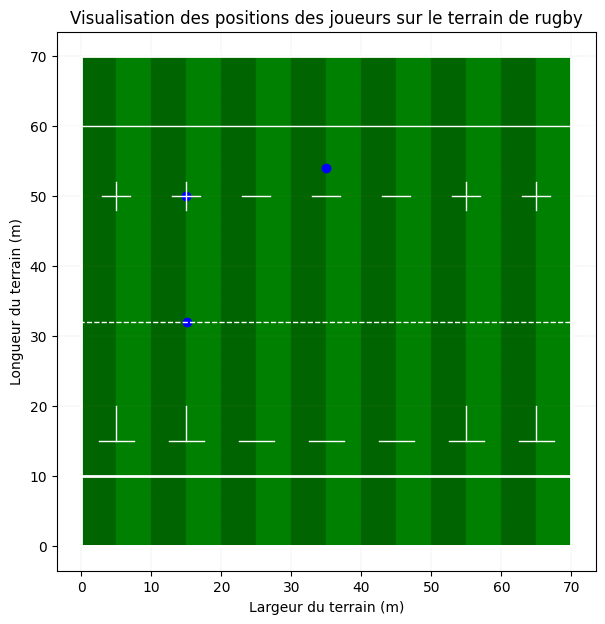

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger les coordonnées depuis le fichier .txt
coordinates = []
with open('penalty_positions.txt', 'r') as file:
    for line in file:
        # Parse uniquement les lignes valides contenant "Frame" et "Position"
        if "Frame" in line and "Position" in line:
            parts = line.strip().split("Position:")[1].strip()
            x, y = map(int, parts.strip("()").split(", "))
            coordinates.append([x, y])

# Vérifier que des coordonnées ont été chargées
if not coordinates:
    print("Erreur : aucune coordonnée trouvée dans le fichier .txt.")
    exit()

# Points en pixels (pour les coins connus de l'image)
image_points = np.array([
    [385, 600],  # Coin en bas à gauche (en pixels)
    [694, 610],  # Coin en bas à droite (en pixels)
    [866, 518],  # Coin en haut à droite (en pixels)
    [629, 513],  # Coin en haut à gauche (en pixels)
], dtype=np.float32)

# Points correspondants dans le monde réel (mètres)
real_points_test = np.array([
    [5, 32],        # Coin bas gauche (en mètres)
    [15, 32],         # Coin bas droit
    [15, 50],        # Coin haut droit
    [5, 50],         # Coin haut gauche
], dtype=np.float32)

# Calculer la matrice d'homographie
H, _ = cv2.findHomography(image_points, real_points_test)

real_points = np.array([
    [0, 0],        # Coin bas gauche (en mètres)
    [70, 0],         # Coin bas droit
    [70, 120],        # Coin haut droit
    [0, 120],         # Coin haut gauche
], dtype=np.float32)

# Convertir les coordonnées des joueurs
player_coords = np.array(coordinates, dtype=np.float32)
player_coords_transformed = cv2.perspectiveTransform(np.array([player_coords]), H)

# Extraire les coordonnées transformées
transformed_coords = player_coords_transformed[0]

# Afficher les coordonnées transformées
print("Coordonnées des joueurs transformées (en mètres) :")
for coord in transformed_coords:
    print(f"Joueur : {coord}")

##### PLOT

plt.figure(figsize=(12, 7))
plt.title("Visualisation des positions des joueurs sur le terrain de rugby")

# Dimensions du terrain en mètres
terrain_width = 70  # Largeur
terrain_length = 70  # Longueur total (100 m terrain + 10 m en-but de chaque côté)
terrain_playable_length = 60  # Longueur du terrain de jeu sans les en-buts

# Tracer les bandes alternées verticales (vert clair et vert foncé)
for i in range(0, terrain_width, 5):
    color = 'darkgreen' if (i // 5) % 2 == 0 else 'green'
    plt.fill_betweenx([0, terrain_length], i, i + 5, color=color)  # Jouable : entre les en-buts

# Tracer le contour du terrain
plt.plot([0, terrain_width, terrain_width, 0, 0],
        [0, 0, terrain_length, terrain_length, 0], color='white', linewidth=2)

# Tracer les lignes principales en blanc
plt.axhline(0, color='white', linestyle='-', linewidth=2)  # Ligne d'en-but (bas)
plt.axhline(10, color='white', linestyle='-', linewidth=2)  # Ligne des 10m (bas de l'en-but)
plt.axhline(22 + 10, color='white', linestyle='--', linewidth=1)  # Ligne des 22 m (bas)
plt.axhline(50 + 10, color='white', linestyle='-', linewidth=1)  # Ligne médiane

# On sélectionne seulement les 2 premières et 2 dernières positions en x
cross_x_positions = [5, 15, terrain_width - 15, terrain_width - 5]  # Positions des croix
for x in cross_x_positions:  # Seules les positions spécifiées
    # Croix en bas (ligne à 5m de l'en-but inférieur)
    plt.plot([x - 2.5, x + 2.5], [15, 15], color='white', linewidth=1)  # Ligne horizontale de la croix
    plt.plot([x, x], [15, 20], color='white', linewidth=1)  # Ligne verticale de la croix
    # Croix en haut (ligne à 5m de l'en-but supérieur)
    plt.plot([x - 2, x + 2], [terrain_length - 20, terrain_length - 20], color='white', linewidth=1)  # Ligne horizontale
    plt.plot([x, x], [terrain_length - 22, terrain_length - 18], color='white', linewidth=1)  # Ligne verticale

# On sélectionne seulement les 3 du milieu 
line_x_positions = [25, 35, 45]  # Positions des croix
for x in line_x_positions:  # Seules les positions spécifiées
    # Ligne en bas (ligne à 5m de l'en-but inférieur)
    plt.plot([x - 2.5, x + 2.5], [15, 15], color='white', linewidth=1)
    # Ligne en haut 
    plt.plot([x - 2, x + 2], [terrain_length - 20, terrain_length - 20], color='white', linewidth=1)

# Tracer les positions des joueurs détectés
x_players, y_players = zip(*transformed_coords)
plt.scatter(x_players, y_players, color='blue')  # Positions des joueurs

# Ajouter des labels pour les axes
plt.xlabel("Largeur du terrain (m)")
plt.ylabel("Longueur du terrain (m)")

# Ajustement du rapport d'aspect et grille discrète pour plus de lisibilité
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(color='gray', linestyle='--', linewidth=0.3, alpha=0.3)
plt.show()
